# Count Vectorization(BOW)

### Load Dependencies

In [ ]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Initial Setup

In [2]:
import sys
import os

sys.path.append(os.path.abspath(".."))  # go to project root

### Load Dataset

In [3]:
data = pd.read_csv(r"..\dataset\processed\clean_dataset.csv", sep=",")
df =data.copy()

df.head()

,news_headline,label
0,donald trump sends embarrass new year eve mess...,0
1,drunk brag trump staffer start russian collusi...,0
2,sheriff david clarke become internet joke thre...,0
3,trump obsess even obama name cod website image,0
4,pope francis call donald trump christmas speech,0


In [4]:
df.shape

(34143, 2)

In [5]:
pd.set_option('display.max_colwidth', 100)
df.sample(5)

,news_headline,label
28446,u meet paris climate deal goal despite court rule white house,1
2552,betsy devos get skewer dept education post embarrassingly misspell tweet,0
21956,turkish foreign minister say assad administration must remove,1
26951,clinton email server break government rule watchdog find,1
2148,trump decide gut united nation funding percent,0


### Separate Label & Text

In [6]:
# Split the dataset

# Features & Target
X = df['news_headline']           
y = df['label']            
X.sample(10)

23768                                                 secretary state shannon meet tillerson u official
21284                                                  saudi say trump visit bolster security trade tie
8990                                                            teen record abuse girl people act video
12571    wow hillary supporter catch undercover camera say okay rip republican voter registration video
30351                                                      eu juncker say brexit talk move second phase
22131                                                     u appeal injunction trump revise travel order
32682                                                france macron tread fine line iran saudi minefield
21474                                          house republicans repeal obamacare hurdle await u senate
24115                                   trump lean toward georgia ex governor agriculture head official
16211                     break flint democrat mayor sue whistle

### Split Dataset

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("X_train size:", X_train.shape)
print("X_test size:", X_test.shape)
print("y_train size:", y_train.shape)
print("y_test size:", y_test.shape)

X_train size: (27314,)
X_test size: (6829,)
y_train size: (27314,)
y_test size: (6829,)


In [8]:
# Check for class imbalancement
y_train.value_counts()

label
0    14050
1    13264
Name: count, dtype: int64

In [9]:
from src.vectorize import get_vectorize

_ , feature_names, X_train_vec, X_test_vec = get_vectorize(X_train, X_test, method='bow', ngram_range= (1,1), min_df= 10 , max_df= 1.0, max_features=10000)

print(len(feature_names))

CountVectorizer
Vectorization completed
Total Features: 10000
3185


In [10]:
X_train_vec[0].toarray()

array([[0, 0, 0, ..., 0, 0, 0]], shape=(1, 3185))

In [11]:
first_doc = X_train_vec[0].toarray()[0]

for word, count in zip(feature_names, first_doc):
    if count > 0:
        print(word, count)

give 1
list 1
magazine 1
make 1
people 1
person 1
president 1
review 1
stun 1
time 1
trump 1
world 1


### CountVectorizer(BOW) Experiments

In [12]:
from utils.vectorizeBOW import *
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [13]:
# Create a empty DataFrame 
# This will store all experiment results

metrics_df = pd.DataFrame()

# Define Model List to Experiment
models = [
    LogisticRegression(), 
    LinearSVC(), 
    MultinomialNB(), 
    RandomForestClassifier(n_estimators= 500, max_depth= 10), 
    XGBClassifier(n_estimators= 500, max_depth= 10)
]
# Define parameters for experimentation
# ngram_vals:
# (1,1) → Only unigrams (single words)
# (1,2) → Unigrams + bigrams
# (1,3) → Unigrams + bigrams + trigrams
# (2,2) → Only bigrams
# Used to control the size and type of word combinations the vectorizer creates.
ngram_vals = [(1, 1), (1, 2), (1, 3), (2, 2)]

# min_df_vals:
# Minimum document frequency threshold.
# A word must appear in at least this many documents to be kept.
# Example:
# min_df=10 → ignore words that appear in fewer than 10 documents.
# Helps remove rare/noisy words.
min_df_vals = [1, 5, 10, 20]

# max_df_vals:
# Maximum document frequency threshold.
# Removes very common words that appear in too many documents.
# Example:
# max_df=0.95 → ignore words that appear in more than 95% of documents.
# Helps remove overly frequent, non-informative words.
max_df_vals = [0.90, 0.95, 0.99]

# Calculate total configs.
total_configs = len(models)*len(ngram_vals)*len(min_df_vals)*len(max_df_vals)
print("Tatal Configurations:", total_configs)

# Configs per model
config_per_model = int(total_configs/len(models))
print("Configs per Model:", config_per_model)

Tatal Configurations: 240
Configs per Model: 48


In [14]:
import itertools
import time
from tqdm import tqdm

# Create full parameter grid
param_grid = list(itertools.product(models, ngram_vals, min_df_vals, max_df_vals))

total_experiments = len(param_grid)
print(f"Total Experiments: {total_experiments}")

results = []
start_time = time.time()

for idx, (model, n, m, j) in enumerate(tqdm(param_grid), 1):

    row = run_bow_experiment(
        model=model,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        ngram_range=n,
        min_df=m,
        max_df=j,
        comments=f"ngram={n}, min_df={m}, max_df={j}"
    )

    results.append(row)

    metrics_df = pd.DataFrame(results)

    end_time = time.time()
print(f"Finished in {(end_time - start_time)/60:.2f} minutes")

Total Experiments: 240


100%|██████████| 240/240 [07:33<00:00,  1.89s/it]

Finished in 7.56 minutes


In [15]:
metrics_df.head()

,model,method,ngram_range,min_df,max_df,max_feature,features_limit,train_acc,test_acc,f1_train,f1_test,gap_percent,comments
0,LogisticRegression,countVectorizer,"(1, 1)",1,0.90,5000,5000,0.9624,0.9288,0.9615,0.9280,3.35,"ngram=(1, 1), min_df=1, max_df=0.9"
1,LogisticRegression,countVectorizer,"(1, 1)",1,0.95,5000,5000,0.9624,0.9288,0.9615,0.9280,3.35,"ngram=(1, 1), min_df=1, max_df=0.95"
2,LogisticRegression,countVectorizer,"(1, 1)",1,0.99,5000,5000,0.9624,0.9288,0.9615,0.9280,3.35,"ngram=(1, 1), min_df=1, max_df=0.99"
3,LogisticRegression,countVectorizer,"(1, 1)",5,0.90,4888,5000,0.9627,0.9280,0.9618,0.9271,3.48,"ngram=(1, 1), min_df=5, max_df=0.9"
4,LogisticRegression,countVectorizer,"(1, 1)",5,0.95,4888,5000,0.9627,0.9280,0.9618,0.9271,3.48,"ngram=(1, 1), min_df=5, max_df=0.95"


In [16]:
# Get best configurated model
metrics_df.sort_values(by= 'f1_test', ascending= False).groupby('model').head(1). reset_index(drop='index')

,model,method,ngram_range,min_df,max_df,max_feature,features_limit,train_acc,test_acc,f1_train,f1_test,gap_percent,comments
0,LogisticRegression,countVectorizer,"(1, 2)",1,0.99,5000,5000,0.9638,0.9291,0.9630,0.9283,3.47,"ngram=(1, 2), min_df=1, max_df=0.99"
1,XGBClassifier,countVectorizer,"(1, 2)",5,0.95,5000,5000,0.9661,0.9262,0.9654,0.9253,4.02,"ngram=(1, 2), min_df=5, max_df=0.95"
2,LinearSVC,countVectorizer,"(1, 2)",5,0.99,5000,5000,0.9821,0.9212,0.9817,0.9197,6.20,"ngram=(1, 2), min_df=5, max_df=0.99"
3,MultinomialNB,countVectorizer,"(1, 1)",5,0.99,4888,5000,0.9355,0.9205,0.9333,0.9179,1.55,"ngram=(1, 1), min_df=5, max_df=0.99"
4,RandomForestClassifier,countVectorizer,"(1, 3)",5,0.99,5000,5000,0.8690,0.8577,0.8709,0.8598,1.11,"ngram=(1, 3), min_df=5, max_df=0.99"


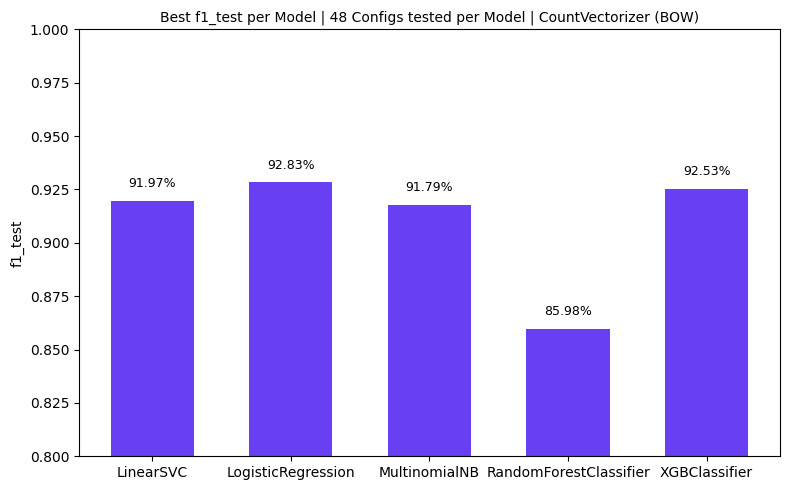

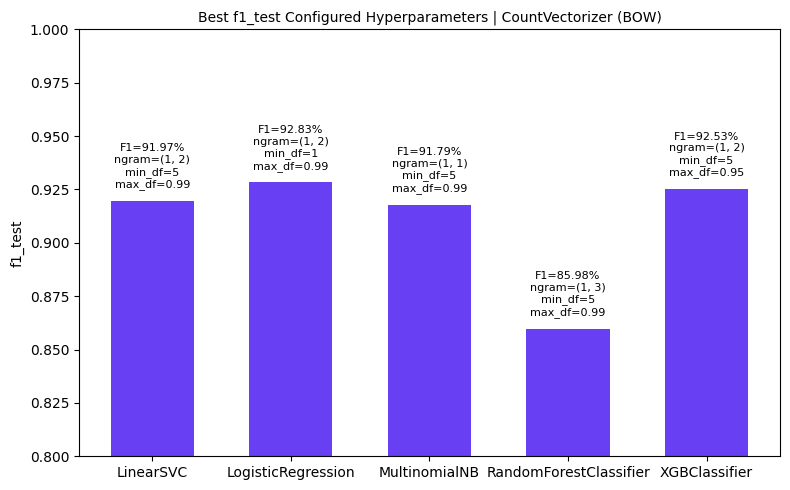

In [17]:
from utils.visualize import plot_best_model_results
plot_best_model_results(metrics_df,'f1_test', total_configs=config_per_model)

In [ ]:
metrics_df.to_csv("../results/BOW_lr_svm_nb_rf_xgb_results_5000.csv")

### Additional Analysis

* Take the best configuration and confirm the results.

In [24]:
from sklearn.metrics import classification_report, confusion_matrix

lr = LogisticRegression()

_, _, lr_X_train_vec, lr_X_test_vec = get_vectorize(
    X_train,
    X_test,
    method='bow',
    ngram_range=(1,2),
    min_df=1,
    max_df=0.99,
    max_features=5000
)

# Fit model
lr_model = lr.fit(lr_X_train_vec, y_train)

# Predictions
y_pred_test = lr_model.predict(lr_X_test_vec)
y_pred_train = lr_model.predict(lr_X_train_vec)

# Classification report (test)
report = classification_report(y_test, y_pred_test)
matrix = confusion_matrix(y_test, y_pred_test)

print("======Classfication Report======")
print(report)
print("========Confusion Matrix========")
print(matrix)

CountVectorizer
Vectorization completed
Total Features: 5000
======Classfication Report======
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3513
           1       0.91      0.94      0.93      3316

    accuracy                           0.93      6829
   macro avg       0.93      0.93      0.93      6829
weighted avg       0.93      0.93      0.93      6829

========Confusion Matrix========
[[3214  299]
 [ 185 3131]]


---

#### Older Experiments Code Version

In [20]:
# # Run experimentation
# for model in models:
#     for n in ngram_vals:
#         for m in min_df_vals:
#             for j in max_df_vals:
#                 row = run_bow_experiment(
#                     model=model,
#                     X_train=X_train,
#                     X_test=X_test,
#                     y_train=y_train,
#                     y_test=y_test,
#                     ngram_range=n,
#                     min_df=m,
#                     max_df=j,
#                     comments=f"ngram={n}, min_df={m}, max_df={j}"
#                 )
#                 metrics_df = pd.concat([metrics_df, pd.DataFrame([row])], ignore_index=True)